# Análise de Mídias Sociais: Twitter

Para autenticar no twitter, temos que criar uma conta e accessar: <br />
http://twitter.com/apps/ <br />
Gerar as chaves de autenticação, ex:<br />
CONSUMER_KEY = 'Riew8e4LKVoEJ51HbeOm6wsYA' <br />
CONSUMER_SECRET = '3pPE1z3kTJGQiY93yCqgLUTURJO2wOcoQCcMbyMbCj4Gm9Hc6N' <br />
OAUTH_TOKEN = '2904474861-kdalTd2NVus3q0PdvAiD3gB2IlF9IFZzao01ol7' <br />
OAUTH_TOKEN_SECRET = '2yHMlMAEUZflpw5swYaLA8EjFyPyPJWnJT84VJoAHDKCU' <br />

## Modulo para autenticação no twitter

In [1]:
import twitter

def oauth_login():
    # XXX: Go to http://twitter.com/apps/new to create an app and get values
    # for these credentials that you'll need to provide in place of these
    # empty string values that are defined as placeholders.
    # See https://dev.twitter.com/docs/auth/oauth for more information 
    # on Twitter's OAuth implementation.
    
    CONSUMER_KEY = 'Riew8e4LKVoEJ51HbeOm6wsYA'
    CONSUMER_SECRET = '3pPE1z3kTJGQiY93yCqgLUTURJO2wOcoQCcMbyMbCj4Gm9Hc6N'
    OAUTH_TOKEN = '2904474861-kdalTd2NVus3q0PdvAiD3gB2IlF9IFZzao01ol7'
    OAUTH_TOKEN_SECRET = '2yHMlMAEUZflpw5swYaLA8EjFyPyPJWnJT84VJoAHDKCU'
    
    auth = twitter.oauth.OAuth(OAUTH_TOKEN, OAUTH_TOKEN_SECRET,
                               CONSUMER_KEY, CONSUMER_SECRET)
    
    twitter_api = twitter.Twitter(auth=auth)
    return twitter_api

# Sample usage
twitter_api = oauth_login()    

# Nothing to see by displaying twitter_api except that it's now a
# defined variable

print (twitter_api)

## Módulo para buscar tweets, dado uma palavra

In [2]:
def twitter_search(twitter_api, q, max_results=1000, **kw):  #max_results=200

    # See https://dev.twitter.com/docs/api/1.1/get/search/tweets and 
    # https://dev.twitter.com/docs/using-search for details on advanced 
    # search criteria that may be useful for keyword arguments
    
    # See https://dev.twitter.com/docs/api/1.1/get/search/tweets    
    search_results = twitter_api.search.tweets(q=q, count=1000, **kw)   # count=100
    
    statuses = search_results['statuses']
    
    # Iterate through batches of results by following the cursor until we
    # reach the desired number of results, keeping in mind that OAuth users
    # can "only" make 180 search queries per 15-minute interval. See
    # https://dev.twitter.com/docs/rate-limiting/1.1/limits
    # for details. A reasonable number of results is ~1000, although
    # that number of results may not exist for all queries.
    
    # Enforce a reasonable limit
    max_results = min(1000, max_results)
    
    for _ in range(10): # 10*100 = 1000
        try:
            next_results = search_results['search_metadata']['next_results']
        except KeyError: # No more results when next_results doesn't exist
            break
            
        # Create a dictionary from next_results, which has the following form:
        # ?max_id=313519052523986943&q=NCAA&include_entities=1
        kwargs = dict([ kv.split('=') 
                        for kv in next_results[1:].split("&") ])
        
        search_results = twitter_api.search.tweets(**kwargs)
        statuses += search_results['statuses']
        
        if len(statuses) > max_results: 
            break
            
    return statuses

## Salvando no MongoDB

In [3]:
import json
import pymongo # pip install pymongo


def save_to_mongo(data, mongo_db, mongo_db_coll, **mongo_conn_kw):
    
    # Connects to the MongoDB server running on 
    # localhost:27017 by default
    
    client = pymongo.MongoClient(**mongo_conn_kw)
    
    # Get a reference to a particular database
    
    db = client[mongo_db]
    
    # Reference a particular collection in the database
    
    coll = db[mongo_db_coll]
    
    # Perform a bulk insert and  return the IDs
    
    return coll.insert_many(data)

def load_from_mongo(mongo_db, mongo_db_coll, return_cursor=False,
                    criteria=None, projection=None, **mongo_conn_kw):
    
    # Optionally, use criteria and projection to limit the data that is 
    # returned as documented in 
    # http://docs.mongodb.org/manual/reference/method/db.collection.find/
    
    # Consider leveraging MongoDB's aggregations framework for more 
    # sophisticated queries.
    
    client = pymongo.MongoClient(**mongo_conn_kw)
    db = client[mongo_db]
    coll = db[mongo_db_coll]
    
    if criteria is None:
        criteria = {}
    
    if projection is None:
        cursor = coll.find(criteria)
    else:
        cursor = coll.find(criteria, projection)

    # Returning a cursor is recommended for large amounts of data
    
    if return_cursor:
        return cursor
    else:
        return [ item for item in cursor ]

## Capturando tweets

In [4]:
q = 'tesla'

twitter_api = oauth_login()
results = []
for i in range(8):
    result = twitter_search(twitter_api, q, max_results=1000)
    print ('capturando ', len(result),' tweets...')
    #results.append(result)
    results += result
#print(type(result))
#print(type(results))
print("Numero de tweets capturados: ", len(results))

#results = twitter_search(twitter_api, q, max_results=1000)
#save_to_mongo(results, 'tweets', q)

capturando  695  tweets...
capturando  696  tweets...
capturando  696  tweets...
capturando  696  tweets...
capturando  696  tweets...
capturando  696  tweets...
capturando  696  tweets...
capturando  696  tweets...
Numero de tweets capturados:  5567


## imprimindo tweets

In [5]:
i = 0
for tweet in results:
    print(tweet['created_at'], ' >> ', tweet['text']) #, " >> ") #, tweet['place'])
    i += 1
    if i > 10:
          break

Thu Apr 05 12:24:57 +0000 2018  >>  $TSLA Short term Elliott wave view, we can be in a wave 4.#elliottwave https://t.co/k8R6xjWspK read this blog.#elliottwave $NQ_F $SPX
Thu Apr 05 12:24:51 +0000 2018  >>  Commented on $AAPL $TSLA https://t.co/Dm2cHgkVYE
Thu Apr 05 12:24:49 +0000 2018  >>  Otro ejemplo de cómo fue posible llevar energía a una ciudad en Filipinas por medio de #PanelesSolares☀️ (Las Vegas… https://t.co/2Nkulh89HO
Thu Apr 05 12:24:49 +0000 2018  >>  RT @ErikVoorhees: Suggestion to Tesla to help with capital problems: Do an ICO (could raise $1-4 billion), wherein the token grants free or…
Thu Apr 05 12:24:40 +0000 2018  >>  La production de la la #TeslaModel3  commence à décoller https://t.co/H3QO3Rez41
Thu Apr 05 12:24:29 +0000 2018  >>  Waarom Tesla geen partij is voor de klassieke autobouwers ... gelezen via https://t.co/1S7ZOOlWwn
Thu Apr 05 12:24:27 +0000 2018  >>  Tesla Inc (NASDAQ: TSLA) Still Struggles While Its Ford Motor Company (NYSE:F) Seems To Be Making It All

## Nuvem de Palavras - tweet

567508


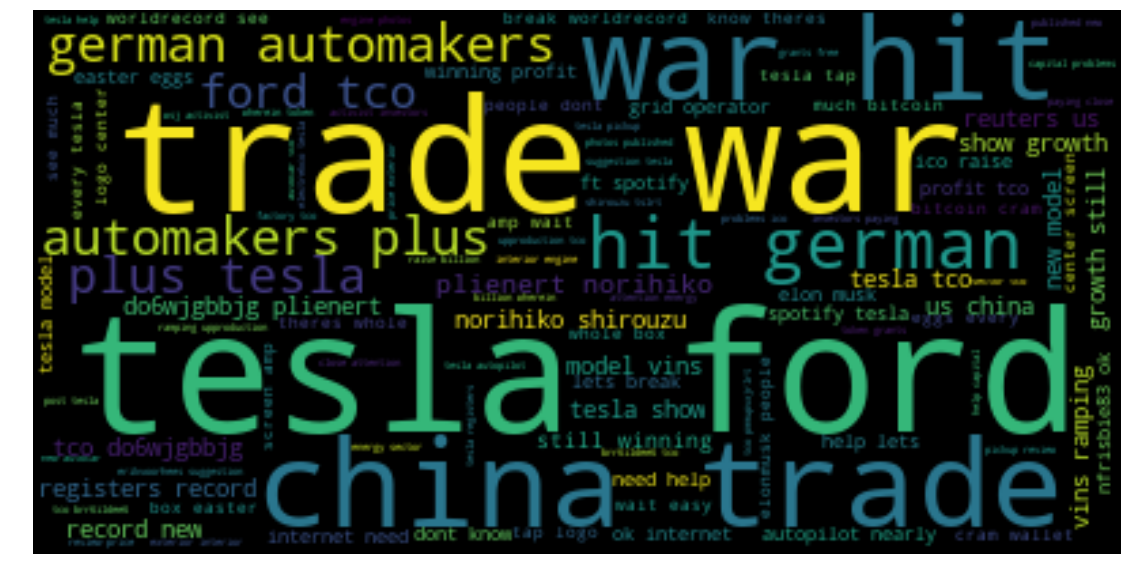

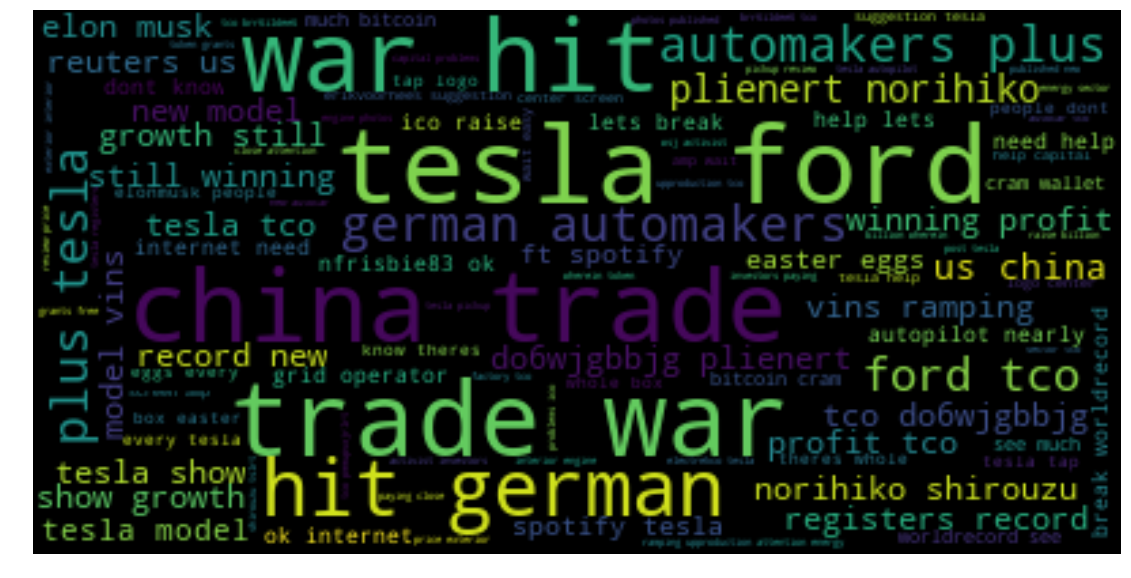

In [11]:
# nuvem de palavras
from wordcloud import WordCloud, STOPWORDS
import re

stext = ""
for tweet in results:
    if 'text' in tweet:
        stext = stext + tweet['text']
stext = stext.lower()

# retirando pontuações e outros caracteres não relevantes
stext = "".join([i for i in stext if ord(i)<128])
stext = stext.replace("http://","")
stext = stext.replace("https://","")
stext = stext.replace("https","")
stext = stext.replace(",","")
stext = stext.replace(".","")
stext = stext.replace("?","")
stext = stext.replace("!","")
stext = stext.replace("#","")
stext = stext.replace("@","")
stext = stext.replace("'","")

text_file = open("stopwords.txt", "r")
lines = text_file.readlines()
stopwords = lines
stopwords = [(word.replace('\n','')).strip() for word in stopwords]

# retirando as stopwords dos tweets
for word in stopwords:
    my_regex = r"\b(?=\w)" + re.escape(word) + r"\b(?!\w)"
    stext = re.sub(my_regex,"" ,stext)

print(len(stext))


# Generate a word cloud image
wordcloud = WordCloud().generate(stext)

# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

# lower max_font_size
wordcloud = WordCloud(max_font_size=40).generate(stext)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Estatistica de contagem de palavras

In [12]:
words = stext.split()

In [13]:
from collections import Counter

c = Counter(words)
#print (c.most_common()[:30])
most_common = c.most_common()[:40]

for i in most_common:
    print (i[0])
#for item in words:  #[words, screen_names, hashtags]:
#    c = Counter(item)
#    print (c.most_common()[:20]) # top 10
#    print 

tesla
the
to
is
in
and
on
of
new
with
model
-
i
by
3
ford
could
hit
teslas
trade
still
help
war
german
automakers
plus
that
plienert
norihiko
be
autopilot
are
vins
via
my
it
4793
over
we
us-china


In [14]:
print (c)

Counter({'tesla': 3448, 'the': 1326, 'to': 1257, 'is': 922, 'in': 901, 'and': 842, 'on': 830, 'of': 694, 'new': 576, 'with': 500, 'model': 494, '-': 437, 'i': 404, 'by': 395, '3': 382, 'ford': 368, 'could': 360, 'hit': 336, 'teslas': 296, 'trade': 296, 'still': 295, 'help': 289, 'war': 288, 'german': 280, 'automakers': 280, 'plus': 280, 'that': 272, 'plienert': 256, 'norihiko': 256, 'be': 249, 'autopilot': 247, 'are': 242, 'vins': 230, 'via': 227, 'my': 226, 'it': 224, '4793': 222, 'over': 222, 'we': 216, 'us-china': 216, 'after': 214, 'an': 210, 'can': 208, 'has': 208, '&amp;': 207, 'you': 200, 'shirouzu': 200, 'show': 196, 'its': 192, 'tco/do6wjgbbjg': 192, 'registers': 190, 'record': 190, 'growth': 188, 'reuters:': 184, 'energy': 184, 'ramping': 182, 'your': 181, 'winning': 180, 'car': 179, 'need': 178, 'la': 176, 'china': 176, 'dont': 175, 'profit': 172, 'how': 170, 'why': 168, 'at': 168, 'nearly': 167, 'most': 167, 'just': 167, 'raise': 166, 'electrekco:': 166, 'than': 164, 'elon'

## colocando as palavras e suas frequencias do twitter num dataframe

In [15]:
import pandas as pd
df = pd.DataFrame(([word, freq] for word, freq in most_common), columns=['Word', 'Frequency'])
df

,Word,Frequency
0,tesla,3448
1,the,1326
2,to,1257
3,is,922
4,in,901
5,and,842
6,on,830
7,of,694
8,new,576
9,with,500


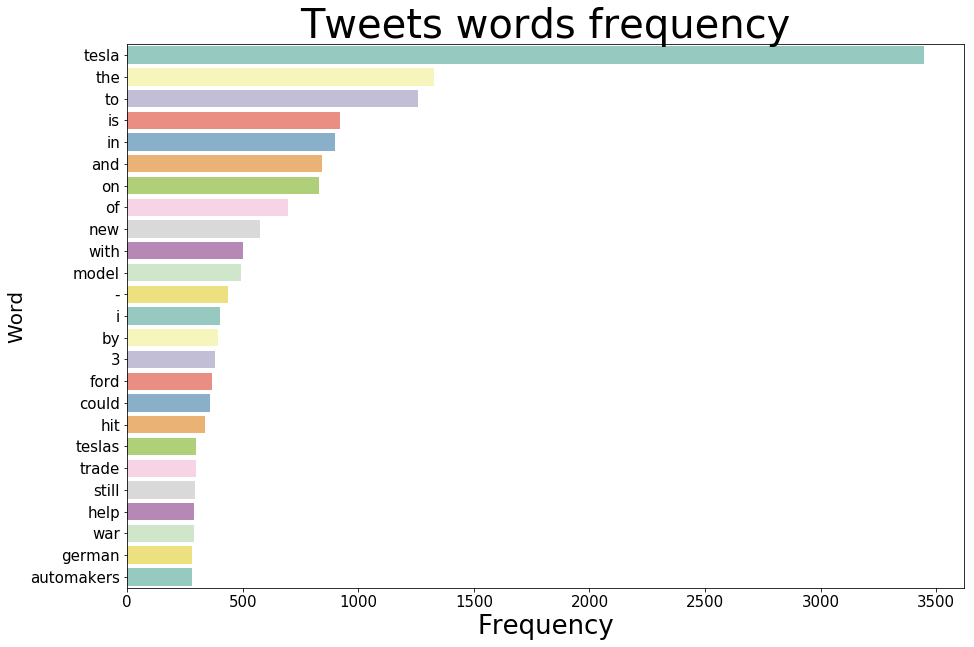

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fig = plt.figure(figsize=(15,10))
fig.add_subplot(1,1,1)

df2 = df[:25]

ax = sns.barplot(y='Word', x = 'Frequency', data=df2, palette="Set3" )
#sns.despine()
ax.set(xlabel='Tweets words frequency', ylabel='Word')
#ax.set(xticks=range(1, 9), xticklabels=list([10,20,30,40,50,60,70,80,90]))

#ax.set(xticklabels=list(range(0,90,10)))
#plt.figure(figsize=(20,10))

ax.axes.set_title("Tweets words frequency",fontsize=40)
ax.set_xlabel("Frequency",fontsize=26)
ax.set_ylabel("Word",fontsize=20)
ax.tick_params(labelsize=15)
#sns.plt.show()
plt.show()

## achar as cidades onde foram gerados os tweets

In [18]:
place = []
for result in results:
    if 'place'in result and result['place']:
        place.append(result['place']['country'])
place = set(place)
print(len(place) )
print(place)

5
{'United States', 'Bolivia', 'Australia', 'Canada', 'The Netherlands'}


In [19]:
place = []
for result in results:
    if 'user'  in result:
        place.append(result['user']['location'])
location = set(place)
len(location)

363

In [20]:
print(location)

{'', 'United States', 'Melbourne, Victoria', 'Goes, Den Haag, Zeeland', 'SA & proud', 'Dallas, TX', 'England', 'The Netherlands', 'New Caledonia', 'New York, New York', 'Vina del Mar', 'Zoetermeer', 'Kendall, FL', 'Los Angeles ', 'Battle & Hastings, England.', 'Allentown, PA', 'Montreal', 'South East Asia', 'Trinidad and Tobago', 'nusantara', 'North Carolina, USA', 'SWEDEN', 'Lucas Valley\r\n', '関西', 'Guatemala', 'Lutry, Suisse', 'Sydney, Cape Breton Island', 'PANAMÁ', 'Australia', 'Long Island, New York', 'Fremont, CA', 'Pachuca de Soto, Hidalgo', 'Oxford Innovation, Oxford, UK', 'Woodford, Queensland', 'United States, UK, Canada, Global', 'México, wey', 'Di sampingmu | Bali ', 'Orlando, FL', 'Serbia', 'Washington D.C. ', 'somewhere near Boston, MA', 'Munich, Germany', 'That Big Island Down-Under', 'Islamabad', 'The Promise Land', 'Jakarta Capital Region', 'Oakland, CA', 'Cleveland, Ohio', 'El Norte', 'stockholm', 'Paris France', 'Sydney via LA', 'Birmingham', 'Sunnyvale, CA', 'tucson

## contar a ocorrencia de cada cidade

In [21]:
from collections import Counter

c = Counter(location)
#print(c)
cidades = c.items()

## colocando as cidades, frequencia num dataframe e salvando no excel

In [22]:
import pandas as pd
df = pd.DataFrame(([cidade, freq] for cidade, freq in cidades), columns=['city', 'frequency'])

# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('cidades.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.
df.to_excel(writer, sheet_name='Sheet1')

# Close the Pandas Excel writer and output the Excel file.
writer.save()
df

,city,frequency
0,,1
1,United States,1
2,"Melbourne, Victoria",1
3,"Goes, Den Haag, Zeeland",1
4,SA & proud,1
5,"Dallas, TX",1
6,England,1
7,The Netherlands,1
8,New Caledonia,1
9,"New York, New York",1


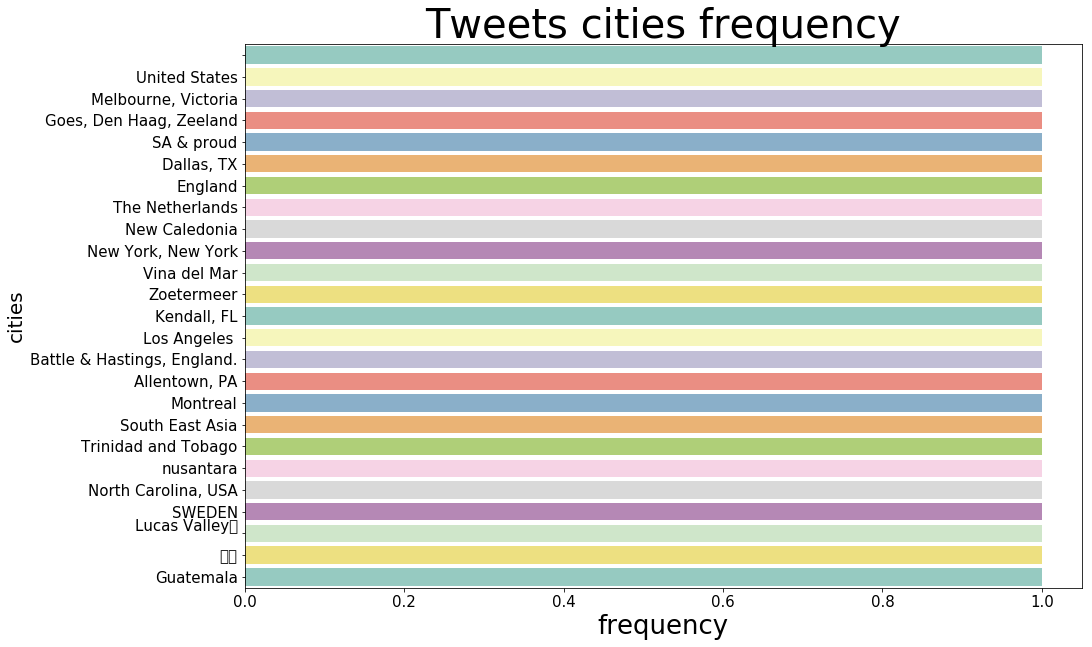

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fig = plt.figure(figsize=(15,10))
fig.add_subplot(1,1,1)

df2 = df[:25]

ax = sns.barplot(y='city', x = 'frequency', data=df2, palette="Set3" )
ax.set(xlabel='Tweets cities frequency', ylabel='cities')
ax.axes.set_title("Tweets cities frequency",fontsize=40)
ax.set_xlabel("frequency",fontsize=26)
ax.set_ylabel("cities",fontsize=20)
ax.tick_params(labelsize=15)
#sns.plt.show()
plt.show()

## conversao de lat, long para cidade

In [14]:
# !pip install reverse_geocoder
import reverse_geocoder as rg

coordinates = (51.5214588,-0.1729636),(9.936033, 76.259952)
coordinates=(37.38605,-122.08385)
results = rg.search(coordinates) # default mode = 2
print (results)

[OrderedDict([('lat', '37.38605'), ('lon', '-122.08385'), ('name', 'Mountain View'), ('admin1', 'California'), ('admin2', 'Santa Clara County'), ('cc', 'US')])]


In [18]:
import reverse_geocoder as rg

#coordinates = (-23.967967, -47.508358)
#cooordinates = (-8.157554, -35.019805 ), (-8.157554, -34.858893)
cordinates = (-43.4161389,-22.8132778)
cordinates = (-22.8132778, -43.4161389)
results = rg.search(coordinates) # default mode = 2
print (results)

[OrderedDict([('lat', '37.38605'), ('lon', '-122.08385'), ('name', 'Mountain View'), ('admin1', 'California'), ('admin2', 'Santa Clara County'), ('cc', 'US')])]


In [38]:
type(results)

list

In [42]:
results[0]['name']

'Pilar do Sul'

## twitter trends - assuntos mais comentados do momento

In [24]:
import json
import twitter

def twitter_trends(twitter_api, woe_id):
    # Prefix ID with the underscore for query string parameterization.
    # Without the underscore, the twitter package appends the ID value
    # to the URL itself as a special-case keyword argument.
    return twitter_api.trends.place(_id=woe_id)

# Sample usage

twitter_api = oauth_login()

# See https://dev.twitter.com/docs/api/1.1/get/trends/place and
# http://developer.yahoo.com/geo/geoplanet/ for details on
# Yahoo! Where On Earth ID

WORLD_WOE_ID = 1
world_trends = twitter_trends(twitter_api, WORLD_WOE_ID)
#print json.dumps(world_trends, indent=1)

US_WOE_ID = 23424977
us_trends = twitter_trends(twitter_api, US_WOE_ID)
#print (json.dumps(us_trends, indent=1))
#us_trends[0]

#for trend in us_trends:
#    print (trend['as_of']['name'])

In [25]:
def find_trends(country_trends):
    trends = country_trends[0]['trends']
    for trend in trends:
        print (trend['name'])

In [26]:
WORLD_WOE_ID = 1
world_trends = twitter_trends(twitter_api, WORLD_WOE_ID)
print ("topicos mais comentados: Mundo")
find_trends(world_trends)

topicos mais comentados: Mundo
#حمله_وطن_بلا_بدوي
#FelizJueves
#BlackBuckPoachingCase
#ThursdayThoughts
#AvukatlarGünü
Spyro
Kurt Cobain
Falciani
アンジュルム
Lamela
Jean-Vincent Placé
Osmangazi Üniversitesi
こいほー
Star India
#sunshine
#5Abr
#من_كثر_ما_البحرين_صغيره
#مذبحه_الاطفال_في_افغانستان
#الخميس_الونيس
#NRLRaidersBulldogs
#طعن_طبيب_في_مستشفي_عرعر
#LulaPresoHoje
#DolarÜçeDüşmeli
#7de7
#Posiciona2018
#AtTheHashtagConvention
#VachaadayyoSaami
#GC2018Swimming
#BAGANIMayari
#bürofloskeln
#HealTheWorldIn5Words
#アベンジャーズファンミご招待
#PolitikCakImin
#タイムショック
#QuintaDetremuraSDV
#LeyAlquileresJustos
#TeachAFilmToCook
#İkinci28ŞubatZKPden
#BitiyorumŞuLafa
#BOOMERANG7thWin
#5aprile
#NationalBurritoDay
#temblor
#تبوك_الان
#WelcomeToDubaiSuperJunior
#자캐의_잘생김_혹은_예쁨_설정_여부
#LANYLiveInManila
#EktaKapoor
#مشتهي_فطور
#ケンミンショー


In [27]:
US_WOE_ID = 23424977
us_trends = twitter_trends(twitter_api, US_WOE_ID)
print ("topicos mais comentados: USA")
find_trends(us_trends)

topicos mais comentados: USA
#ThursdayThoughts
#TheMasters
#HealTheWorldIn5Words
#AtTheHashtagConvention
#NationalBurritoDay
Mike Rizzo
Salman Khan
Rex Tillerson's $12
Delta Air Lines
When Terrorists Run City Hall
Maribel Perez Wadsworth
Happy Friday Eve
Dr. Evil
Jamie Dimon
Wanda Greene
Gospel Light Baptist Church
Marc Jacobs
Spyro
Bette Davis
Johnny Valiant
Crosstown
Lake Shore Drive
Everybody Knows
World Bank
Layne Staley
Lula da Silva
But Trump
F-16
AP Forever
Pharrell Williams
#TimesItCanGetAwkward
#SLCBoston
#TeachAFilmToCook
#JERZDAY
#ITMod18
#atosdigital
#OpeningDaySTL
#FenwayPark
#MorningJoe
#KurtCobain
#ShellKnew
#SaheedVassell
#GoldStarSpousesDay
#SocialJusticeBandName
#Zimbabwe
#CommonwealthGames2018
#VachaadayyoSaami
#Daybreak
#CAREFORME
#bfc530


In [28]:
BR_WOE_ID = 23424768
br_trends = twitter_trends(twitter_api, BR_WOE_ID)
print ("topicos mais comentados: Brasil")
find_trends(br_trends)

topicos mais comentados: Brasil
#LulaPresoHoje
#QuintaDetremuraSDV
Nem 9h
Com o Supremo
#MaisTwitterEhMenos
Chico Pinheiro
#BDSP
#SorrindoPraVida
Eduardo Paes
Alerj
Rodoanel
Após 1
Carlinhos Brown
Barra da Tijuca
Foro Privilegiado
Máfia da Merenda
EUA e China
Sepúlveda Pertence
Aecio
Paulinho
Liverpool
Marco Aurélio
Carmen Lúcia
Rodrigo Caio
Roma
Habeas Corpus
Cristiano Ronaldo
Barça
Monagas
Lewandowski
De Rossi
Villas Boas
Evander
Messi
#GauchaHoje
#bdmg
#GabaritandoÉtica
#98Esportes
#LaTorcidaDePapel
#HK7s
#DancingBrasil
#SandyNoTVZ
#PremiosMTVMiaw
#Inter109Anos
